In [1]:
import torch
import torch.nn.functional as F
from torch import optim
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

首先创建数据集，每个句子都以EOS结束，以PAD填充.翻译时以EOS开始

In [2]:
PAD, BOS, EOS = '<pad>', '<bos>', '<eos>'
#设置每个句子最长为10
max_length = 10

In [3]:
def process_seq(seq_tokens, word_tokens, seqs):
    for i in seq_tokens:
        if i not in word_tokens:
            word_tokens[i] = max(word_tokens.values())+1
    seq_tokens += [EOS]+[PAD]*(max_length-len(seq_tokens)-1)
    seqs.append(seq_tokens)

In [4]:
en_word_tokens = {
    '<pad>':0,
    '<bos>':1,
    '<eos>':1
}#存词-索引字典
fr_word_tokens = {
    '<pad>':0,
    '<bos>':1,
    '<eos>':2
}
en_seqs = []#输入数据的索引数据
fr_seqs = []
with open('data\\eng-fra.txt', 'r', encoding='utf8') as f:
    lines = f.readlines()
    for line in lines:
        en_seq, fr_seq = line.strip().split('\t')
        en_tokens, fr_tokens = en_seq.strip().split(' '), fr_seq.strip().split(' ')
        if max(len(en_tokens), len(fr_tokens)) > max_length-1:
            continue
        process_seq(en_tokens, en_word_tokens, en_seqs)
        process_seq(fr_tokens, fr_word_tokens, fr_seqs)

In [5]:
def getData(word_tokens, seqs):
    data = [[word_tokens[j] for j in i] for i in seqs]
    return torch.LongTensor(data)

In [6]:
en_data = getData(en_word_tokens, en_seqs)

In [7]:
fr_data = getData(fr_word_tokens, fr_seqs)

In [8]:
data = TensorDataset(en_data, fr_data)

In [37]:
#参数配置表
batch_size = 1
en_word_nums = len(en_word_tokens.keys())
fr_word_nums = len(fr_word_tokens.keys())
embedding_size = 128
gru_hidden_size = 128
attention_size = 64

In [38]:
dataset = DataLoader(data, batch_size=batch_size, shuffle=True)

In [39]:
re_en_words_tokens = {value:key for key, value in en_word_tokens.items()}
re_fr_words_tokens = {value:key for key, value in fr_word_tokens.items()}

In [40]:
for i in dataset:
    en_seq, fr_seq = i
    print(i)
    for j in range(batch_size):
        print(' '.join([re_en_words_tokens[i] for i in en_seq.numpy()[j]]), '->', ' '.join([re_fr_words_tokens[i] for i in fr_seq.numpy()[j]]))
    break

[tensor([[  31, 3075,  247,  487,  420, 2123,  111, 2220,    1,    0]]), tensor([[   19,    49,  5270,    68, 12881,  1113,  4315,     2,     0,     0]])]
I'm lucky to have you as a friend. <eos> <pad> -> Je suis chanceux de t'avoir pour ami. <eos> <pad> <pad>


In [49]:
class Encoder(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_size, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.num_layer = 1
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size,self.num_layer, batch_first=True)
    
    def forward(self, data_input, init_hidden):
        self.data_embd = self.emb(data_input)
        outputs, h = self.gru(self.data_embd, init_hidden)
        return outputs, h
    
    def init_hidden(self):
        return torch.zeros(self.num_layer, self.batch_size,self.hidden_size)

In [50]:
class Attention(nn.Module):
    def __init__(self, input_size, attention_size):
        super(Attention, self).__init__()
        self.linear1 = nn.Linear(input_size, attention_size)
        self.tanh = nn.Tanh()
        self.linear2 = nn.Linear(attention_size,1)
    
    def forward(self,encode_states, decode_states):
        decode_states = decode_states.squeeze(0).unsqueeze(1)
        decode_states, encode_states = torch.broadcast_tensors(decode_states, encode_states)
        en_de_states = torch.cat((encode_states, decode_states), dim=2)
        l1 = self.linear1(en_de_states)
        l2 = self.tanh(l1)
        l3 = self.linear2(l2)
        weights = nn.Softmax(dim=1)(l3)
        contexts = torch.mul(weights,encode_states).sum(dim=1).unsqueeze_(0)
        return contexts, weights

In [51]:
class Decoder(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_size, attention_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.num_embeddings = num_embeddings
        self.num_layer = 1
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        self.gru = nn.GRU(embedding_dim+hidden_size, hidden_size, self.num_layer, batch_first=True)
        self.attention = Attention(2*gru_hidden_size, attention_size)
        self.output = nn.Linear(self.hidden_size, self.num_embeddings)
    
    def forward(self, data_input, encode_states, decode_states):
        self.data_embd = self.emb(data_input)
        self.contexts, self.weights = self.attention(encode_states, decode_states)
        self.contexts = self.contexts.squeeze(0).unsqueeze(1)
        self.data = torch.cat((self.data_embd, self.contexts), dim = 2)
        outputs, h = self.gru(self.data, decode_states)
        y = self.output(outputs)
        outputs = F.log_softmax(y, dim=2)
        return outputs.squeeze(1), h


In [52]:
def batch_loss(encoder, decoder, batch_size, input_tensor, target_tensor, lossf):
    init_encode_hidden = encoder.init_hidden()
    encode_states, en_h0 = encoder(input_tensor, init_encode_hidden)
    dec_input = torch.LongTensor([fr_word_tokens[BOS]] * batch_size).view(batch_size,-1)
    decode_states = en_h0
    mask, num_not_pad_tokens = torch.ones(batch_size), 0
    batchloss = torch.tensor(0.0)
    for y in target_tensor.transpose(0,1):
        outputs, decode_states = decoder(dec_input, encode_states, decode_states)
        batchloss += (mask*lossf(outputs, y)).sum()
        dec_input = y.view(batch_size,-1)
        num_not_pad_tokens += mask.sum().item()
        t = y != torch.LongTensor([fr_word_tokens[EOS]])
        mask = mask * (t.float())
        #print(batchloss, num_not_pad_tokens)
    return batchloss/num_not_pad_tokens

In [53]:
def get_random_data(en_data, fr_data, num):
    idx = torch.randint(low=0, high=len(en_data), size = (num,))
    return en_data[idx,:].view(-1,max_length), fr_data[idx,:].view(-1,max_length)

In [54]:
encoder = Encoder(en_word_nums, embedding_size, gru_hidden_size, batch_size)
decoder = Decoder(fr_word_nums, embedding_size, gru_hidden_size, attention_size)

In [55]:
epoch = 20
epo_bat = 50
loss = []
encode_optimizer = optim.SGD(encoder.parameters(), lr=0.01, momentum=0.9)
decode_optimizer = optim.SGD(decoder.parameters(), lr=0.01, momentum=0.9)
lossf = nn.NLLLoss()

In [56]:
for i in range(epoch):
    input_tensors, target_tensors = get_random_data(en_data, fr_data, epo_bat)
    for j in range(epo_bat):
        input_tensor, target_tensor = input_tensors[i,:].view(-1,max_length), target_tensors[i,:].view(-1,max_length)
        encoder.zero_grad()
        decoder.zero_grad()
        batchloss = batch_loss(encoder, decoder, batch_size, input_tensor, target_tensor, lossf)
        batchloss.backward()
        encode_optimizer.step()
        decode_optimizer.step()
        loss.append(batchloss.item())
        print('epoch:',i, 'epoch_b', j, 'loss:',batchloss)

epoch: 0 epoch_b 0 loss: tensor(10.4609, grad_fn=<DivBackward0>)
epoch: 0 epoch_b 1 loss: tensor(10.4261, grad_fn=<DivBackward0>)
epoch: 0 epoch_b 2 loss: tensor(10.3601, grad_fn=<DivBackward0>)
epoch: 0 epoch_b 3 loss: tensor(10.2661, grad_fn=<DivBackward0>)
epoch: 0 epoch_b 4 loss: tensor(10.1471, grad_fn=<DivBackward0>)
epoch: 0 epoch_b 5 loss: tensor(10.0057, grad_fn=<DivBackward0>)
epoch: 0 epoch_b 6 loss: tensor(9.8442, grad_fn=<DivBackward0>)
epoch: 0 epoch_b 7 loss: tensor(9.6643, grad_fn=<DivBackward0>)
epoch: 0 epoch_b 8 loss: tensor(9.4676, grad_fn=<DivBackward0>)
epoch: 0 epoch_b 9 loss: tensor(9.2547, grad_fn=<DivBackward0>)
epoch: 0 epoch_b 10 loss: tensor(9.0260, grad_fn=<DivBackward0>)
epoch: 0 epoch_b 11 loss: tensor(8.7812, grad_fn=<DivBackward0>)
epoch: 0 epoch_b 12 loss: tensor(8.5192, grad_fn=<DivBackward0>)
epoch: 0 epoch_b 13 loss: tensor(8.2387, grad_fn=<DivBackward0>)
epoch: 0 epoch_b 14 loss: tensor(7.9379, grad_fn=<DivBackward0>)
epoch: 0 epoch_b 15 loss: ten

KeyboardInterrupt: 

In [57]:
import matplotlib.pyplot as plt

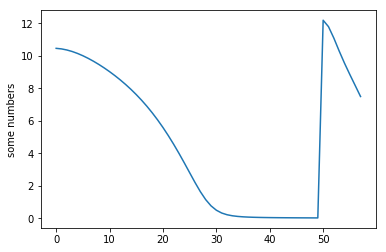

In [58]:
plt.plot(loss)
plt.ylabel('some numbers')
plt.show()

In [59]:
index = torch.randint(low=0, high=len(en_data), size = (50,))

In [60]:
def predict(encoder, decoder, input_tensor):
    init_encode_hidden = torch.zeros(1,1,128)
    encode_states, en_h0 = encoder(input_tensor, init_encode_hidden)
    decode_states = en_h0
    dec_input = torch.LongTensor([fr_word_tokens[BOS]] * 1).view(1,-1)
    pred_tokens = []
    for _ in range(max_length):
        outputs, decode_states = decoder(dec_input, encode_states, decode_states)
        pred = outputs.argmax(dim=1)
        pred_token = re_fr_words_tokens[pred.item()]
        if pred_token == EOS:
            break
        else:
            dec_input = pred.view(-1,1)
            pred_tokens.append(pred_token)
    return ' '.join(pred_tokens)

In [61]:
index

tensor([ 94317,  37035,  87330, 108005, 100095,  54012,  66127,  60659,  17929,
         19612,   3364,  51565,   7827,  21761, 106184, 106226,  25508,  66734,
         70958,  57745,  18636,  95461,  18577,  29399,  40445,   4547,  17796,
         45849,   3599,  23927,   3315,  70496,  25553, 101639,  57824,  60602,
         52346,  78851,  32392,  84310,  62354,   6985,  60297,  55212,  37511,
         58030,  41783,     57,  10098,  34792])

In [62]:
testid = 0
for idx in index:
    input_tensor,target_tensor = en_data[idx,:].view(1,-1), fr_data[idx,:].view(1,-1)
    print('**********************************','testid:',testid,'**********************************')
    print(' '.join([re_en_words_tokens[i] for i in input_tensor.numpy()[0]]), '->', ' '.join([re_fr_words_tokens[i] for i in target_tensor.numpy()[0]]))
    print(predict(encoder, decoder, input_tensor))
    testid += 1
    

********************************** testid: 0 **********************************
I wonder why karaoke is so popular. <eos> <pad> <pad> -> Je me demande pourquoi le karaoké est aussi populaire. <eos>
Mon vélo a un pneu à plat.
********************************** testid: 1 **********************************
Do you play any sports? <eos> <pad> <pad> <pad> <pad> -> Pratiques-tu quelque sport ? <eos> <pad> <pad> <pad> <pad> <pad> <pad>
Mon vélo a un pneu à plat.
********************************** testid: 2 **********************************
I want to know why this happened. <eos> <pad> <pad> -> Je veux savoir pourquoi ceci s'est produit. <eos> <pad> <pad>
Mon vélo a un pneu à plat.
********************************** testid: 3 **********************************
They spent the afternoon around the pool. <eos> <pad> <pad> -> Elles ont passé l'après-midi autour de la piscine. <eos> <pad>
Mon vélo a un pneu à plat.
********************************** testid: 4 **********************************
She

********************************** testid: 36 **********************************
Does anyone speak English? <eos> <pad> <pad> <pad> <pad> <pad> -> Quiconque parle-t-il anglais ? <eos> <pad> <pad> <pad> <pad> <pad>
Mon vélo a un pneu à plat.
********************************** testid: 37 **********************************
I really can't leave right now. <eos> <pad> <pad> <pad> -> Je ne peux vraiment pas partir immédiatement. <eos> <pad> <pad>
Mon vélo a un pneu à plat.
********************************** testid: 38 **********************************
He became a policeman. <eos> <pad> <pad> <pad> <pad> <pad> -> Il est devenu policier. <eos> <pad> <pad> <pad> <pad> <pad>
Mon vélo a un pneu à plat.
********************************** testid: 39 **********************************
She tends to be late for school. <eos> <pad> <pad> -> Elle a tendance à arriver en retard à l'école. <eos>
Mon vélo a un pneu à plat.
********************************** testid: 40 **********************************
Wr